In [478]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from numpy.fft import fft, ifft


from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [479]:
# This sets up the figure size
plt.rcParams['figure.figsize'] = [6, 6]

In [480]:
data = pd.read_csv('jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


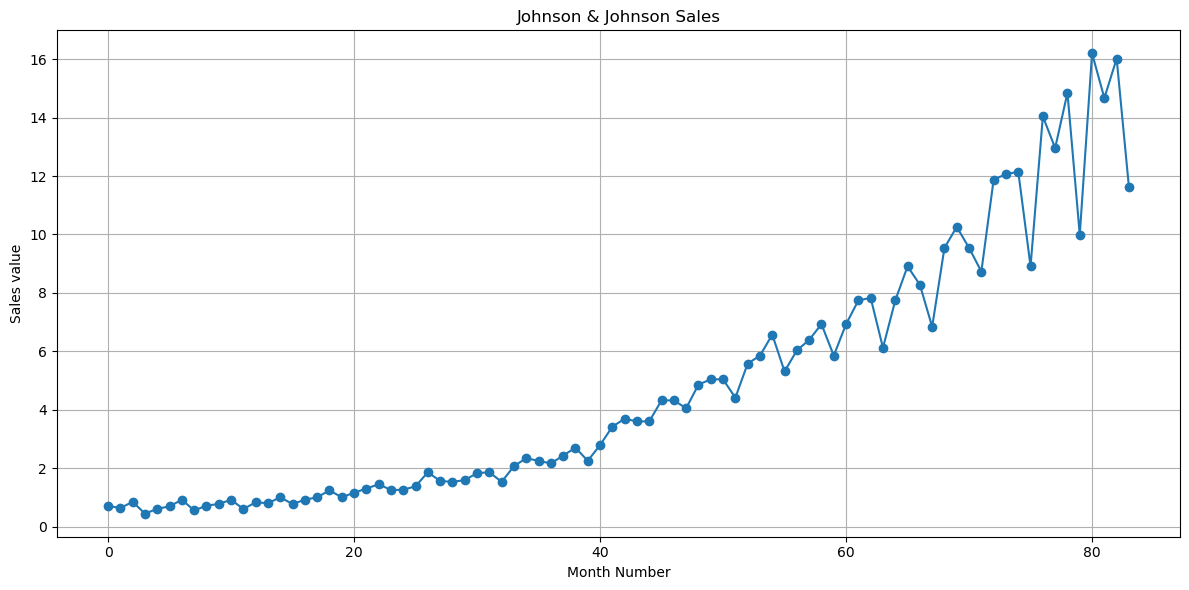

In [481]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['data'], marker='o')
plt.title('Johnson & Johnson Sales')
plt.xlabel('Month Number')
plt.ylabel('Sales value')
plt.grid(True)
plt.tight_layout()
plt.show()

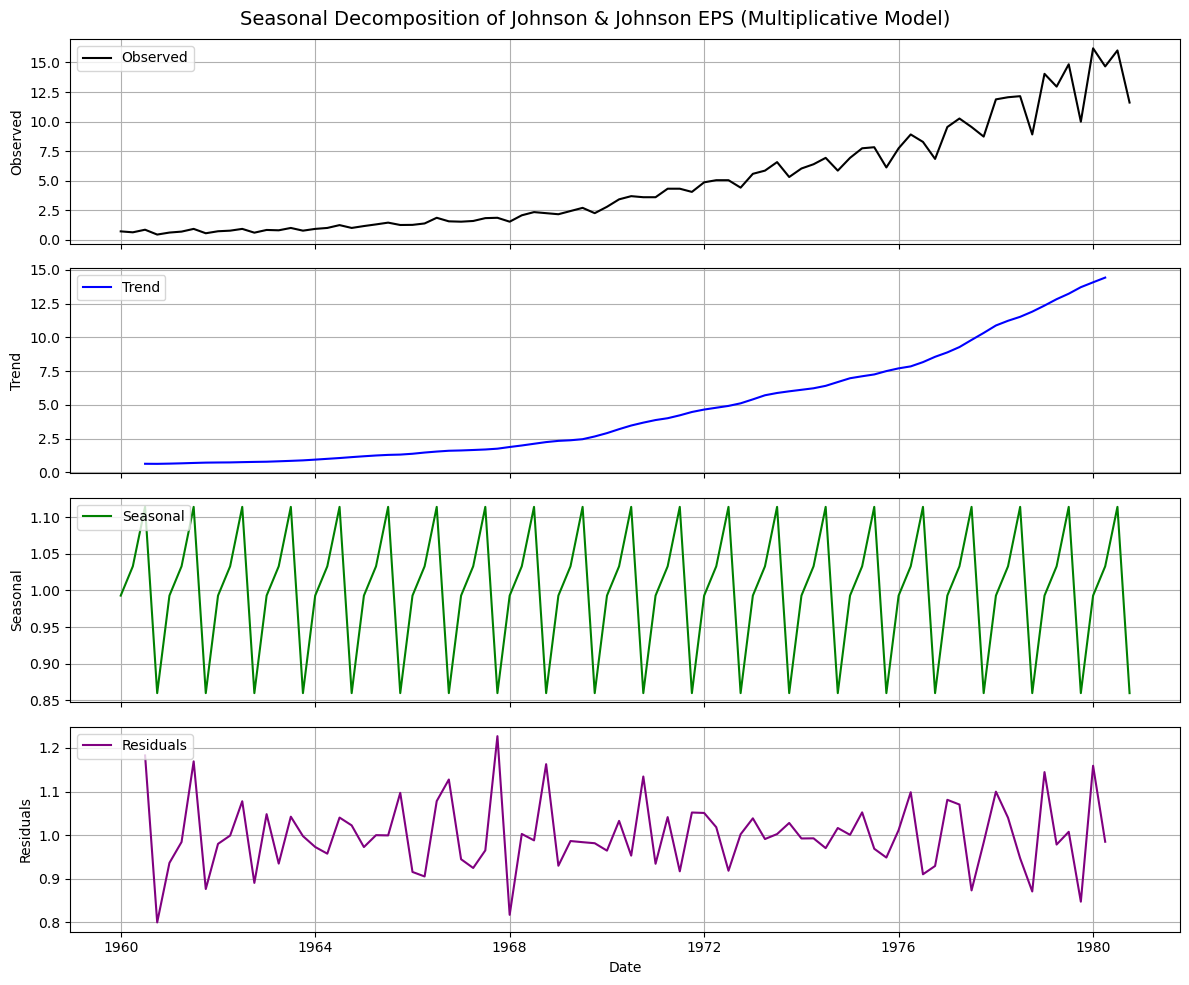

In [482]:



data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Perform seasonal decomposition (quarterly = period 4)
result = seasonal_decompose(data['data'], model='multiplicative', period=4)

# Plot full seasonal decomposition with residuals as a line plot
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Observed
axes[0].plot(result.observed, label='Observed', color='black')
axes[0].set_ylabel('Observed')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Trend
axes[1].plot(result.trend, label='Trend', color='blue')
axes[1].set_ylabel('Trend')
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Seasonal
axes[2].plot(result.seasonal, label='Seasonal', color='green')
axes[2].set_ylabel('Seasonal')
axes[2].legend(loc='upper left')
axes[2].grid(True)

# Residuals (line plot)
axes[3].plot(result.resid, label='Residuals', color='purple')
axes[3].set_ylabel('Residuals')
axes[3].legend(loc='upper left')
axes[3].grid(True)

# Final formatting
fig.suptitle('Seasonal Decomposition of Johnson & Johnson EPS (Multiplicative Model)', fontsize=14)
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('decomposejj.png', dpi=300)
plt.show()



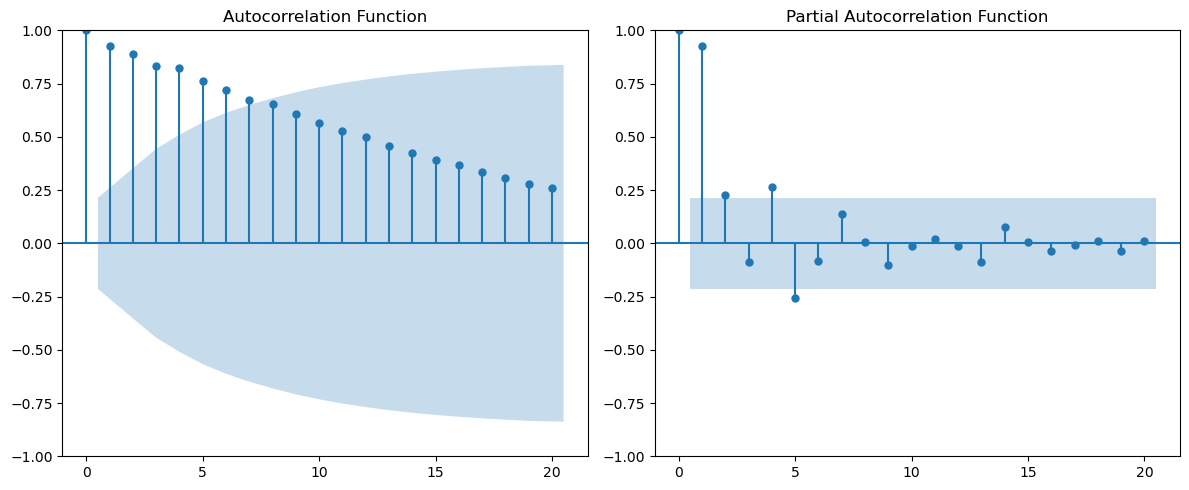

In [483]:
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(data['data'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(data['data'], ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [484]:
# Perform ADF test
result = adfuller(data['data'])

# Print results
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])


ADF Test Statistic: 2.742016573457468
p-value: 1.0


In [485]:
# take the log()

data['data_log'] = np.log(data['data'])

# then take the first difference
data['data_tr_1'] = data['data_log'].diff()

data.head(10)

,data,data_log,data_tr_1
date,,,
1960-01-01,0.71,-0.342490,NaN
1960-04-01,0.63,-0.462035,-0.119545
1960-07-02,0.85,-0.162519,0.299517
1960-10-01,0.44,-0.820981,-0.658462
1961-01-01,0.61,-0.494296,0.326684
1961-04-02,0.69,-0.371064,0.123233
1961-07-02,0.92,-0.083382,0.287682
1961-10-01,0.55,-0.597837,-0.514455
1962-01-01,0.72,-0.328504,0.269333


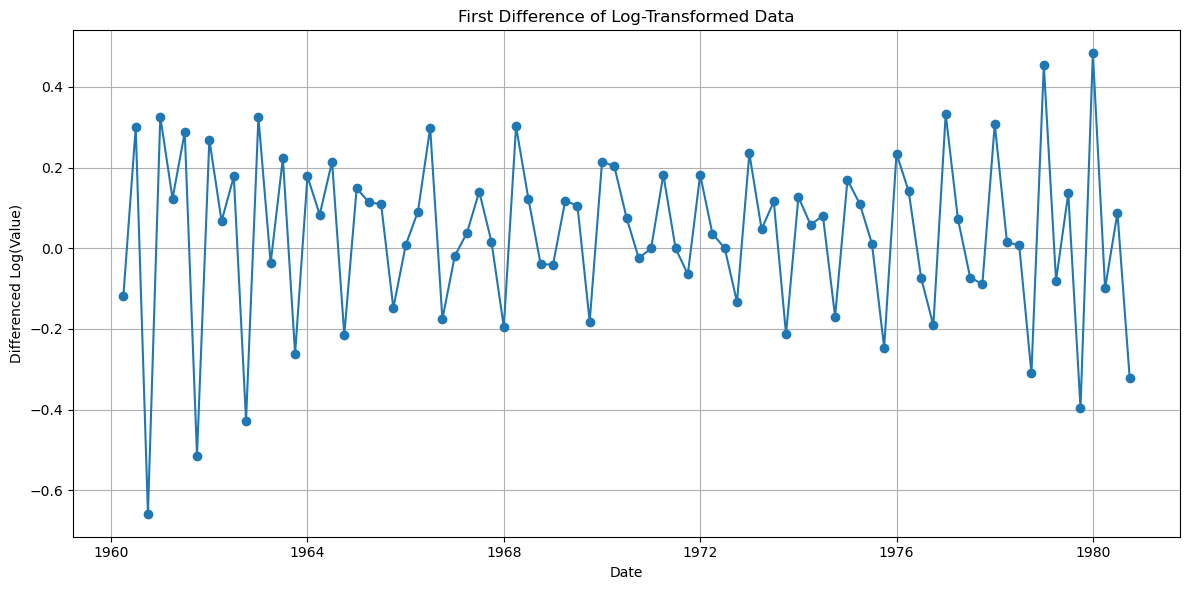

In [486]:
# Plot the differenced log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(data['data_tr_1'], marker='o')
plt.title('First Difference of Log-Transformed Data')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Value)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [487]:
# Drop NA values before ADF test
adf_result = adfuller(data['data_tr_1'].dropna())

# Print ADF test results
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])



ADF Test Statistic: -4.317043945811826
p-value: 0.0004149731404440838


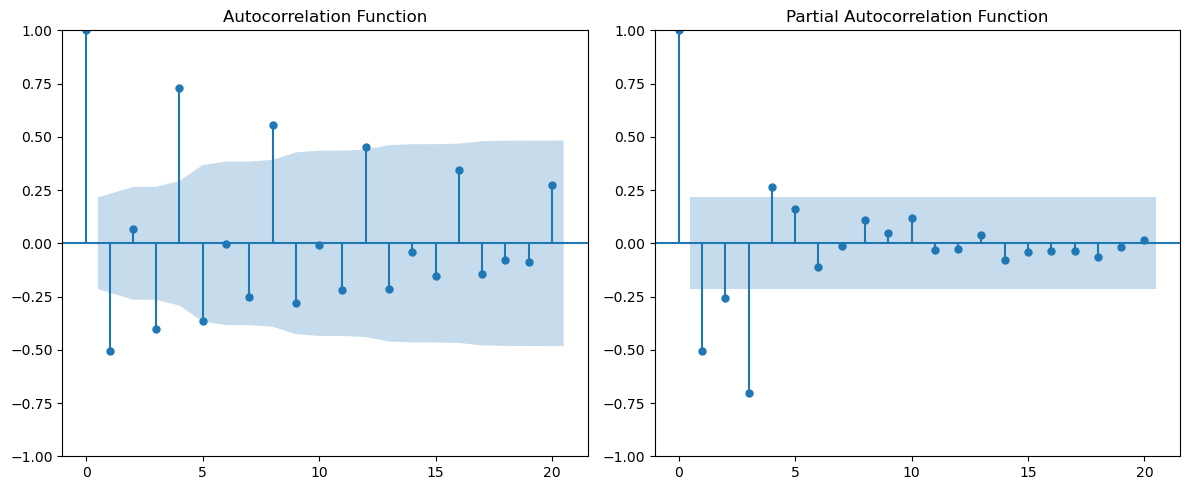

In [488]:
# Drop NA values
series = data['data_tr_1'].dropna()
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(series, ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(series, ax=plt.gca(), lags=20, method='ywm')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [489]:


def optimize_ARIMA(endog, order_list):
    """
    Return dataframe with parameters and corresponding AIC
    
    order_list - list with (p, d, q) tuples
    endog - the observed variable, e.g., data['data']
    """
    results = []
    
    for order in tqdm(order_list):  # tqdm_notebook → tqdm for broader compatibility
        try: 
            model = ARIMA(endog, order=order)
            model_fit = model.fit()
            aic = model_fit.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Failed for order {order}: {e}")
            continue

    # Check for empty result list
    if not results:
        print("No models were successfully fitted.")
        return pd.DataFrame(columns=['(p, d, q)', 'AIC'])

    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [490]:


ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

    
# print out the first few rows of order_list to check it looks right
order_list[:10]



[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [491]:
# call opitimize_ARIMA

result_df = optimize_ARIMA(data['data'], order_list)


# print out the ordered list. The best model fit (lowest AIC) will be shown at the top
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.499079
1,"(4, 1, 6)",115.859346
2,"(7, 1, 1)",116.050993
3,"(5, 1, 3)",116.535767
4,"(5, 1, 4)",117.242710
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [492]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


from pmdarima.model_selection import train_test_split
train, test = train_test_split(data['data'], train_size=82)

model = pm.auto_arima(train, seasonal=False, m=1, test='adf',max_p=6, max_q=6)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -46.634
Date:                Fri, 11 Apr 2025   AIC                            113.268
Time:                        18:13:29   BIC                            137.212
Sample:                             0   HQIC                           122.875
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4654      0.142    -10.350      0.000      -1.743      -1.188
ar.L2         -0.7419      0.159     -4.678      0.000      -1.053      -0.431
ar.L3          0.0390      0.075      0.521      0.6

In [493]:

from statsmodels.tsa.arima.model import ARIMA

# p,d,q ARIMA Model
best_model = ARIMA(data['data'], order=(6,1,3))

best_model_fit = best_model.fit()

In [494]:
#summary of the model
print(best_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -47.750
Date:                Fri, 11 Apr 2025   AIC                            115.499
Time:                        18:13:29   BIC                            139.687
Sample:                             0   HQIC                           125.217
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4420      0.123    -11.685      0.000      -1.684      -1.200
ar.L2         -0.7324      0.147     -4.983      0.000      -1.020      -0.444
ar.L3          0.0448      0.063      0.714      0.4

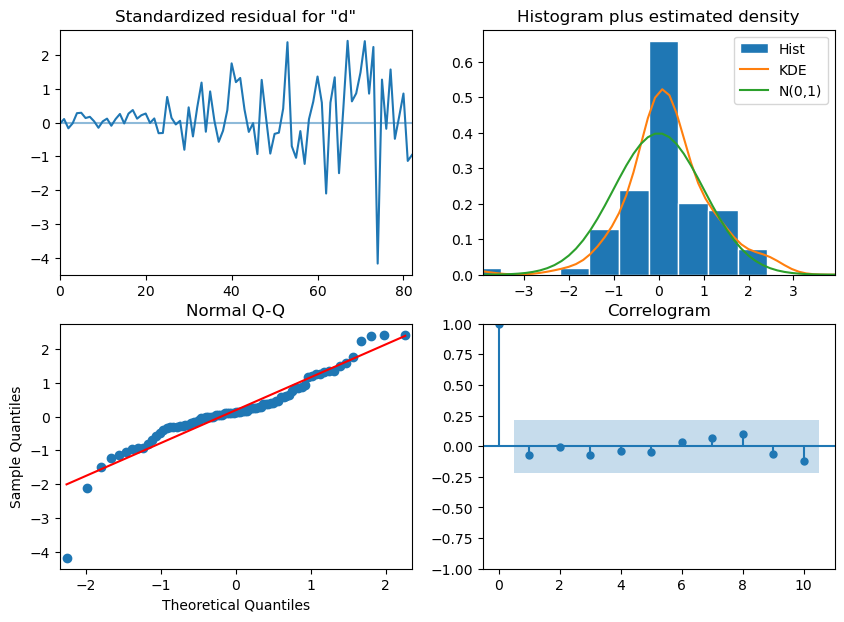

In [495]:
best_model_fit.plot_diagnostics(figsize=(10,7))
plt.show()

In [496]:
#get prediction start and end dates
test_data = data['data']

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
predictions = best_model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

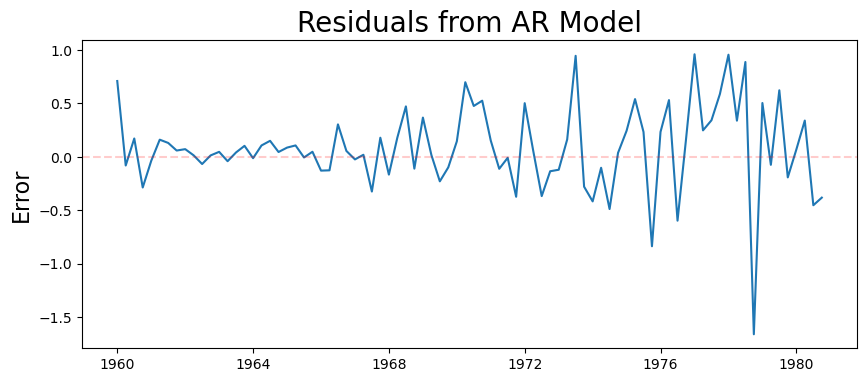

In [497]:
# plot the residuals

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

In [498]:
# Assess the root mean square of the residuals

print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.4014519180598638


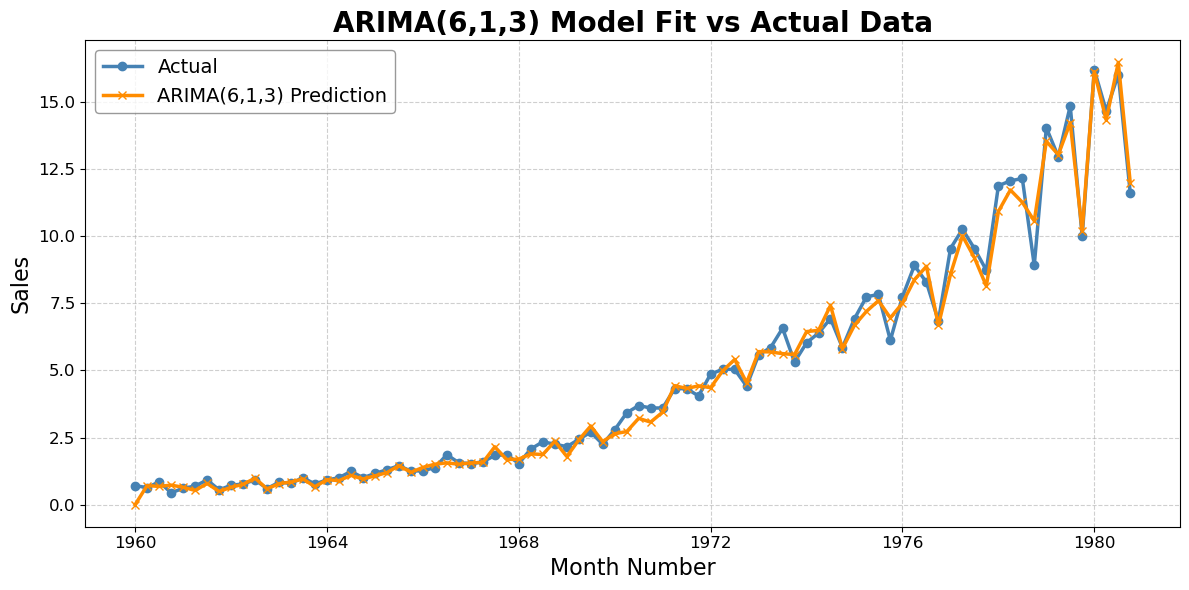

In [499]:

plt.figure(figsize=(12, 6))

# Plot data and predictions
plt.plot(test_data, label='Actual', linewidth=2.5, marker='o', color='steelblue')
plt.plot(predictions, label='ARIMA(6,1,3) Prediction', linewidth=2.5, marker='x', color='darkorange')

# Styling
plt.title('ARIMA(6,1,3) Model Fit vs Actual Data', fontsize=20, fontweight='bold')
plt.xlabel('Month Number', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.legend(fontsize=14, frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.6)

# Axis formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [500]:
def forecast_accuracy(forecast, actual):
    # Convert to NumPy arrays in case they're Pandas Series
    forecast = np.array(forecast)
    actual = np.array(actual)

    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]  # Correlation

    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)           # MinMax

    return {
        'mape': mape,
        'me': me,
        'mae': mae,
        'mpe': mpe,
        'rmse': rmse,
        'corr': corr,
        'minmax': minmax
    }


In [501]:
metrics = forecast_accuracy(predictions, test_data)
print(metrics)


{'mape': 0.08953174692770698, 'me': -0.08212304061317352, 'mae': 0.27978918370673084, 'mpe': -0.028306925300629584, 'rmse': 0.4014519180598638, 'corr': 0.9957906520720566, 'minmax': 0.08447863354817342}


In [502]:
# use get_forecast() for this

# make the predictions for 24 steps ahead
predictions_int = best_model_fit.get_forecast(steps=26)
predictions_int.predicted_mean

84     17.318008
85     16.505319
86     17.146921
87     13.404121
88     18.879281
89     17.830380
90     18.667666
91     14.994480
92     20.416802
93     19.301742
94     19.982448
95     16.760702
96     21.824003
97     20.796382
98     21.345389
99     18.427688
100    23.309560
101    22.217110
102    22.743642
103    20.084013
104    24.755913
105    23.668827
106    24.112733
107    21.744856
108    26.188342
109    25.105267
Name: predicted_mean, dtype: float64

In [503]:
# get a better view
predictions_int.conf_int()

,lower data,upper data
84,16.540113,18.095902
85,15.701993,17.308644
86,16.278358,18.015484
87,12.534876,14.273366
88,17.452122,20.306440
89,16.377447,19.283313
90,17.109555,20.225777
91,13.407733,16.581227
92,18.414340,22.419264
93,17.224678,21.378805


In [504]:
# add the predicted mean column in

conf_df = pd.concat([predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

conf_df.head()

,predicted_mean,lower data,upper data
84,17.318008,16.540113,18.095902
85,16.505319,15.701993,17.308644
86,17.146921,16.278358,18.015484
87,13.404121,12.534876,14.273366
88,18.879281,17.452122,20.306440


In [505]:
# change the name of the column heads

conf_df = conf_df.rename(columns={'predicted_mean': 'Predictions', 'lower data': 'Lower CI', 'upper data': 'Upper CI'})
conf_df.head()

,Predictions,Lower CI,Upper CI
84,17.318008,16.540113,18.095902
85,16.505319,15.701993,17.308644
86,17.146921,16.278358,18.015484
87,13.404121,12.534876,14.273366
88,18.879281,17.452122,20.306440


In [506]:

forecast_steps = len(conf_df)
last_date = data.index[-1]  
future_index = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_steps, freq='Q')


conf_df.index = future_index


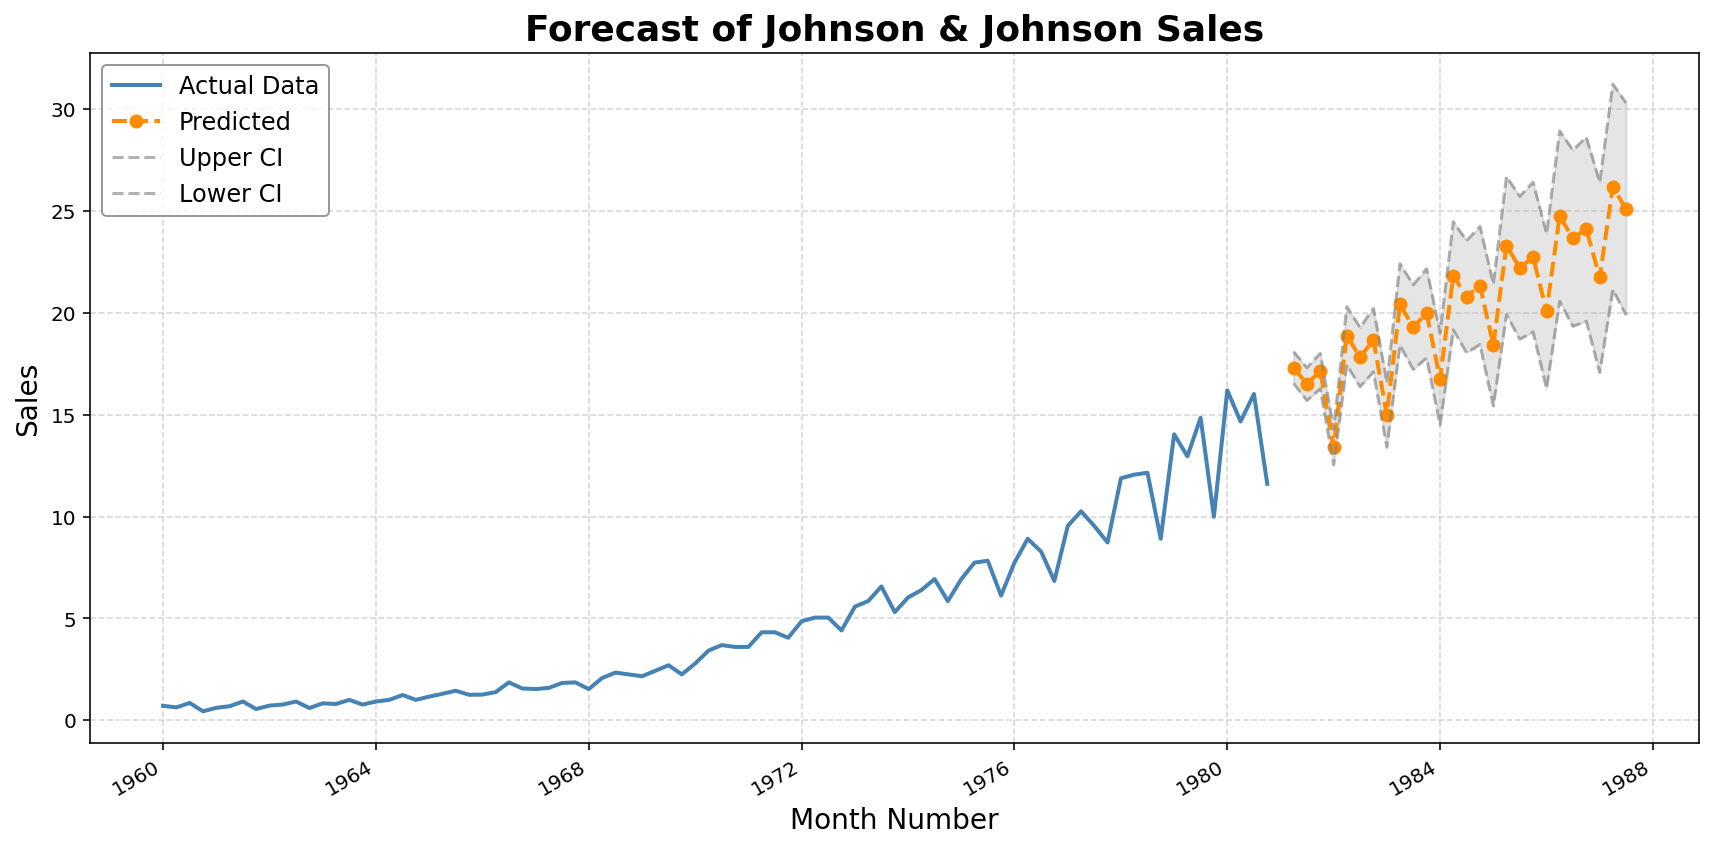

In [507]:


fig, ax = plt.subplots(figsize=(12, 6), dpi=144)

# Plot original data
ax.plot(data['data'], color='steelblue', linewidth=2, label='Actual Data')

# Plot predictions
conf_df['Predictions'].plot(ax=ax, color='darkorange', linewidth=2, linestyle='--', marker='o', label='Predicted')

# Confidence interval bounds
conf_df['Upper CI'].plot(ax=ax, color='gray', linestyle='dashed', alpha=0.6, label='Upper CI')
conf_df['Lower CI'].plot(ax=ax, color='gray', linestyle='dashed', alpha=0.6)

# Fill between upper and lower confidence intervals
ax.fill_between(conf_df.index, conf_df['Lower CI'], conf_df['Upper CI'], color='gray', alpha=0.2)

# Labels and title
ax.set_title('Forecast of Johnson & Johnson Sales', fontsize=18, fontweight='bold')
ax.set_xlabel('Month Number', fontsize=14)
ax.set_ylabel('Sales', fontsize=14)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12, loc='upper left', frameon=True, facecolor='white', edgecolor='gray')

# Tidy layout
plt.tight_layout()
plt.savefig('sales_pred.png', dpi=300)
plt.show()


In [508]:
values = data['data'].values.reshape(-1, 1)
# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)


In [509]:
# Parameters
window_size = 24
forecast_steps = 24


In [510]:
# Create sliding windows
X, y = [], []
for i in range(len(scaled) - window_size - forecast_steps + 1):
    X.append(scaled[i:i+window_size])
    y.append(scaled[i+window_size:i+window_size+forecast_steps].flatten())
X, y = np.array(X), np.array(y)

In [511]:
# Split into train/test
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [512]:
# Build model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(forecast_steps)
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# 24-step forecast into the future
last_input = scaled[-window_size:].reshape(1, window_size, 1)
forecast_scaled = model.predict(last_input)[0]
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.1246 - val_loss: 0.3972
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1234 - val_loss: 0.3785
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1196 - val_loss: 0.3504
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1047 - val_loss: 0.3073
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0843 - val_loss: 0.2570
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0775 - val_loss: 0.2277
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0671 - val_loss: 0.2159
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0647 - val_loss: 0.1993
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0580 - val_loss: 0.1832
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0539 - val_loss: 0.1726
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0463 - val_loss: 0.1550
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0397 - val_loss: 0.1237


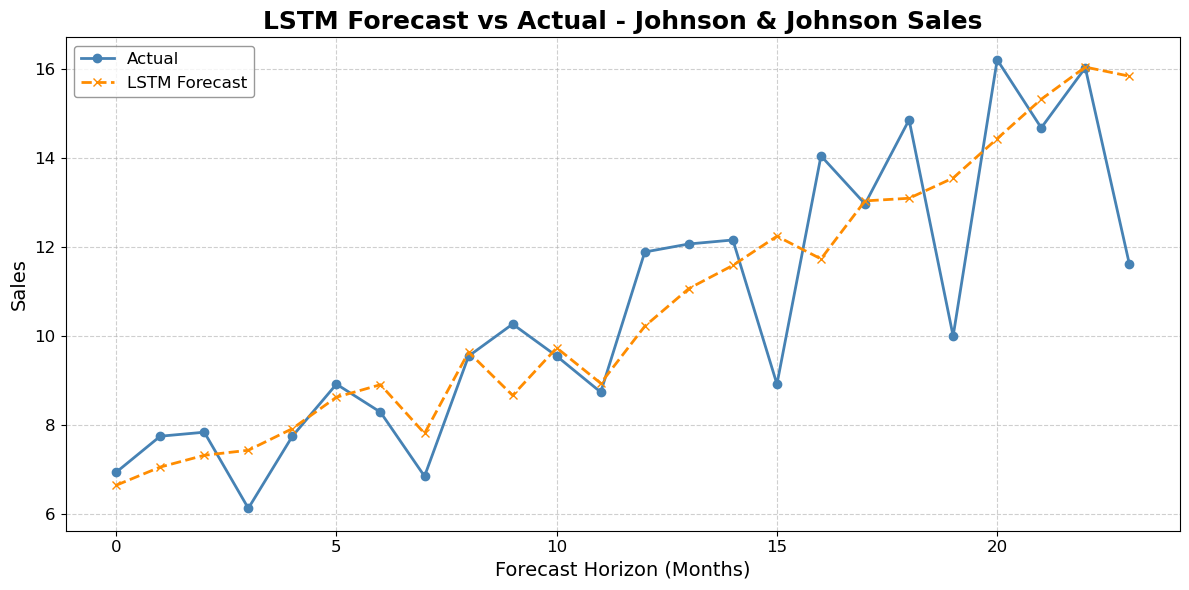

In [513]:

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(forecast_steps), actual_future, label='Actual', marker='o', color='steelblue', linewidth=2)

# Plot forecasted values
plt.plot(range(forecast_steps), pred_rolling, label='LSTM Forecast', marker='x', color='darkorange', linewidth=2, linestyle='--')

# Add title and labels
plt.title('LSTM Forecast vs Actual - Johnson & Johnson Sales', fontsize=18, fontweight='bold')
plt.xlabel('Forecast Horizon (Months)', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray')

# Improve tick formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Layout
plt.tight_layout()
plt.show()


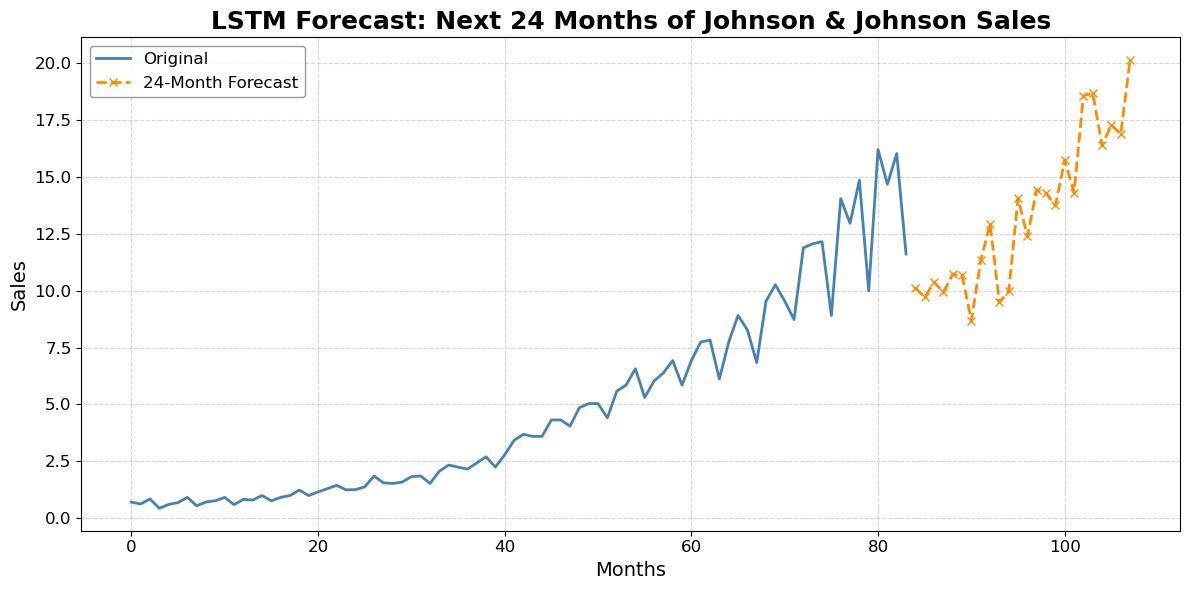

In [514]:

plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(range(len(values)), values, label='Original', color='steelblue', linewidth=2)

# Plot LSTM forecast
plt.plot(
    range(len(values), len(values) + forecast_steps),
    forecast,
    label='24-Month Forecast',
    color='darkorange',
    linestyle='--',
    linewidth=2,
    marker='x'
)

# Titles and labels
plt.title('LSTM Forecast: Next 24 Months of Johnson & Johnson Sales', fontsize=18, fontweight='bold')
plt.xlabel('Months', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Styling
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("lstmjj.png", dpi=300)
plt.show()


In [515]:
# RMSE evaluation
rmse = np.sqrt(mean_squared_error(actual_future, pred_rolling))
print(f"RMSE for 24-step rolling forecast: {rmse:.3f}")

RMSE for 24-step rolling forecast: 1.636


In [516]:


# Load JJ dataset
jj_df = pd.read_csv('jj.csv', parse_dates=['date'], index_col='date')

# Extract the EPS values
jj_array = jj_df['data'].values  

# Apply FFT
X_jj = fft(jj_array)



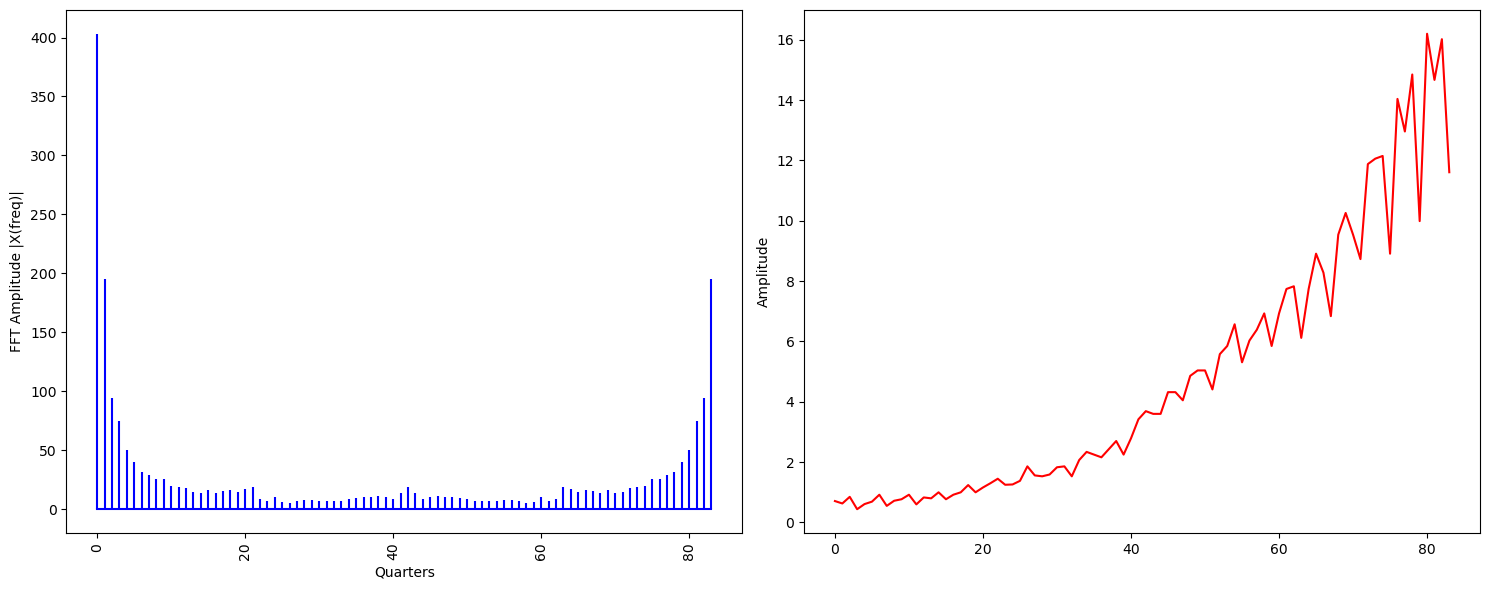

In [517]:
# Plotting
plt.figure(figsize=(15, 6))

# Subplot 1: FFT amplitude stem plot
plt.subplot(121)
plt.stem(np.abs(X_jj), 'b', markerfmt=" ", basefmt="-b")
plt.xticks(rotation=90)
plt.xlabel('Quarters')
plt.ylabel('FFT Amplitude |X(freq)|')

# Subplot 2: IFFT (reconstructed signal)
plt.subplot(122)
plt.plot(ifft(X_jj).real, 'r')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
